<div align="center">

# Preprocessing Petawawa Research Forest Data

### Author: Harry Seely

</div>

![prf_image](https://opendata.nfis.org/mapserver/PRF_Layout.jpg)

This notebook provides python code to preprocess the Petawawa Research Forest (PRF) inventory and ancillary datasets.

All data is sourced from the following website: 

https://opendata.nfis.org/mapserver/PRF.html

Please consult this page to get the most up to date version of the PRF data.

## Python Environment Setup <a class="anchor" id="env-setup"></a>

This tutorial is offered in Google Collab format primarily, but can also be run locally using jupyter notebooks.

**Environment setup is performed using the [uv package manager](https://docs.astral.sh/uv/) which will need to be installed to run the code.**

The uv package manager allows for the installation of specific package versions to maintain reproducibility. The list of packages and their versions is included in the `pyproject.toml` file. Read more about using PyTorch with uv in this [documentation](https://docs.astral.sh/uv/guides/integration/pytorch/).

**This code has been tested on Windows 11**

1. Open a terminal and check that uv is installed by running 

    ```
    uv
    ```

2. Ensure uv is up-to-date by running

    ```
    uv self update
    ```

3. Intialize the uv environment and install dependencies.

    ```
    uv sync
    ```

## Notes

- Species codes were manually entered into the `sp_codes.csv` based on a table provided in the "AFRIT_PRF_Lidar_Inventory_Field_Protocols_June 9_2014.pdf"

## Script Parameters

In [1]:
DOWNLOAD_DATA = False

MAP_PLOT_NETWORK = False

DATA_DIR = r'data/original'

OUT_DATA_DIR = r'data'

 ## Load Packages <a class="anchor" id="load-packages"></a>

In [2]:
import os
import pandas as pd
import geopandas as gpd
import requests, zipfile, io
import zipfile
import matplotlib.pyplot as plt
import rasterio
import rioxarray as rio
import numpy as np
import laspy
import contextily as cx
from shapely import geometry
from rasterio.plot import show
from pprint import pprint
import shutil
from glob import glob

## Define functions for later use

In [3]:
def download_zip(url, outdir):

    if os.path.basename(url).split(".")[0] == ".zip":

        r = requests.get(url)

        z = zipfile.ZipFile(io.BytesIO(r.content))

        z.extractall(outdir)
    
    else:
        r = requests.get(url)
        
        with open(os.path.join(outdir, os.path.basename(url)), 'wb') as f:
            f.write(r.content)

def plot_pc(pc, pt_size=60, plt_size=5, cmap='jet', margin_lim=0.05,bg_col="black"):
    """
    Function for plotting point cloud data.
    """

    fig = plt.figure(figsize=(plt_size, plt_size))
    plt.subplots_adjust(top=1 - margin_lim,
                    bottom=0 + margin_lim,
                    right=1 - margin_lim,
                    left=0 + margin_lim,
                    hspace=0,
                    wspace=0)
    
    ax = fig.add_subplot(projection='3d')

    ax.scatter(pc[:, 0],
               pc[:, 1],
               pc[:, 2],
               c=pc[:, 2],
               cmap=cmap,
               linewidth=1,
               alpha=1,
               s=pt_size)

    ax.set_axis_off()

    ax.set_facecolor(bg_col)

def write_las(xyz, out_fpath):

    header = laspy.LasHeader(point_format=3, version="1.4")
    header.offsets = np.min(xyz, axis=0)
    header.scales = np.array([0.1, 0.1, 0.1])

    las = laspy.LasData(header)

    las.x = xyz[:, 0]
    las.y = xyz[:, 1]
    las.z = xyz[:, 2]

    las.write(out_fpath)

## Download Data <a class="anchor" id="download-data"></a>

In [4]:
# Whether to download data (only needs to be done once, but some time...)

url_dict = {

# 'prf_boundary': r"https://opendata.nfis.org/downloads/petawawa/Vector/Boundaries/prf_boundary.zip",

# 'plot_data_2014': r"https://opendata.nfis.org/downloads/petawawa/Vector/Forest%20Sample%20Plots/prf_forest_sample_plots_2014.zip",

# 'plot_data_2018': r"https://opendata.nfis.org/downloads/petawawa/Vector/Forest%20Sample%20Plots/SPL2018_EFI_ground_plots.zip",

# 'wet_areas': r"https://opendata.nfis.org/downloads/petawawa/Raster/Wet%20Areas%20Mapping/PRF_WAM.zip"

# 'lidar_rasters': r"https://opendata.nfis.org/downloads/petawawa/Raster/LiDAR_2018/PRF_LiDAR2018_Predictors.zip",

# 'dtm': r"https://opendata.nfis.org/downloads/petawawa/Raster/LiDAR_2018/prf_spl2018_dtm_50cm_wgs84.zip",

# 'lidar': r"https://opendata.nfis.org/downloads/petawawa/Raster/LiDAR_2018/PRF_LiDAR2018_LAS.zip"

}

pprint(url_dict)

{}


In [5]:

# Create a directory to store the data
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

In [6]:
if DOWNLOAD_DATA:
    
    for key, url in url_dict.items():   

            print(f"Downloading {key}...")

            download_zip(url, DATA_DIR)


# Check files in data directory
downloaded_ls = os.listdir(DATA_DIR)
print("\n".join(downloaded_ls))


AFRIT_PRF_Lidar_Inventory_Field_Protocols_June 9_2014.pdf
Final AFRIT-PRF Plot Summary for Don.xlsx
forest_sample_plots_thumbnails.png
lidar
petawawa_field_data_protocol2018_PRF.pdf
petawawa_s2_2018.tif
petawawa_s2_2024.tif
Points
Polygons
prf_bbox.cpg
prf_bbox.dbf
prf_bbox.prj
prf_bbox.shp
prf_bbox.shx
prf_boundary
prf_spl2018_dtm_50cm_wgs84.tif
PRF_WAM
SPL2018_EFI_ground_plots
SPL2018_EFI_predictors
sp_codes.csv


## Clean Tree and Plot Data <a class="anchor" id="clean-data"></a>

In [7]:
# PRF Boundary
boundary_gdf = gpd.read_file(os.path.join(DATA_DIR, 'prf_boundary/prf_boundary.shp'))

<Axes: >

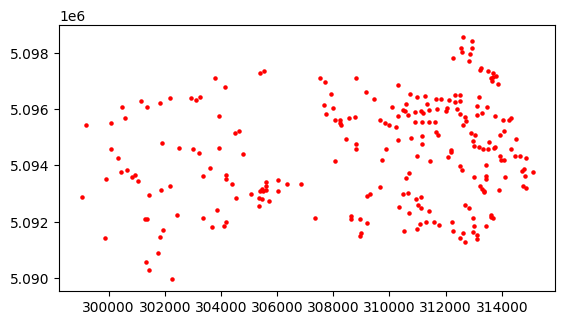

In [8]:
# Read plot data

plots_2018_fpath = os.path.join(DATA_DIR, r'SPL2018_EFI_ground_plots/PRF_SPL2018_EFI_plots_pts_wgs84.shp')
plots_2018_gdf = gpd.read_file(plots_2018_fpath)

plots_2018_gdf.plot(color='red', markersize=5)

In [9]:
sp_codes_fpath = os.path.join(DATA_DIR, r"sp_codes.csv")

trees_fpath = os.path.join(DATA_DIR, r"SPL2018_EFI_ground_plots/PRF_CNL_SPL_CalibrationData_LiveDeadStems.xlsx")

sp_codes_df = pd.read_csv(sp_codes_fpath)

trees_df = (pd.read_excel(trees_fpath, sheet_name="Tree").\
            merge(sp_codes_df, how='left', left_on='TreeSpec', right_on='MNR Code ').\
            drop(columns=['tree_spec', 'TreeSpec', 'MNR Code ', 'MNR Species', 'HLF', 
                          'HtFlag', 'phf', 'CD_ht', 'Int_ht', 'BA_all', 'TPH_all', 
                          'domht', 'ht_meas', 'stems', 'QualityClass']).\
            rename(columns={'Name ': 'species', 
                            "Ht": "height",}))

sp_col = trees_df.pop('species')
trees_df.insert(2, 'species', sp_col)

trees_df

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
0,PRF001,24.0,White pine,P,D,10.1,NaN,1.0,11.552521,0.128190,N,0.000000,0.708735,393.396400,Poles
1,PRF001,46.0,White pine,P,D,9.9,NaN,2.0,11.422529,0.123163,N,0.000000,0.673254,375.305379,Poles
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,PRF334,NaN,Sugar Maple,N,L,3.7,NaN,NaN,8.893640,0.215043,N,0.000000,0.858564,851.191939,Under
12586,PRF334,NaN,Sugar Maple,N,L,3.3,NaN,NaN,8.500000,0.171060,N,0.000000,0.653868,659.084439,Under
12587,PRF334,NaN,Sugar Maple,N,L,3.2,NaN,NaN,8.395967,0.160850,N,0.000000,0.607493,615.333049,Under
12588,PRF334,NaN,Sugar Maple,N,L,3.0,NaN,NaN,7.400000,0.141372,N,0.000000,0.469656,521.064025,Under


In [10]:
trees_df.columns

Index(['PlotName', 'TreeID', 'species', 'Origin', 'Status', 'DBH',
       'CrownClass', 'DecayClass', 'height', 'baha', 'codom', 'mvol', 'tvol',
       'biomass', 'size'],
      dtype='object')

## Make a map of PRF Plots

In [11]:

if MAP_PLOT_NETWORK:
    
    # Convert to web mercator for plotting
    plots_2018_gdf_wm = plots_2018_gdf.to_crs(epsg=3857)

    ax = plots_2018_gdf_wm.plot(facecolor="orange", 
                        edgecolor='black',
                        markersize=15,
                        linewidth=0.5)

    boundary_gdf.to_crs(epsg=3857).plot(ax=ax, 
                                        color='none', 
                                        edgecolor='black', 
                                        linewidth=1.5,
                                        alpha=0.5)

    cx.add_basemap(ax, attribution='')

    # Remove axis labels and ticks
    ax.set_axis_off()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Add title
    ax.set_title("PRF Ground Plots", fontsize=16, fontweight='bold', loc='center')

    # Save plot to file
    plt.savefig(r"images/prf_ground_plots_map.png", dpi=300, bbox_inches='tight')



## Clean water data

In [12]:
water_fpath = os.path.join(DATA_DIR, r"PRF_WAM/prf_waterpolygons.shp")

water_gdf = gpd.read_file(water_fpath)[['DESCR', 'LABEL', 'geometry']].\
    rename(columns={'DESCR': 'type', 'LABEL': 'name'})
    
water_gdf.insert(0, 'id', range(1, len(water_gdf) + 1))

water_gdf

,id,type,name,geometry
0,1,"Wetland Area, Permanent",None,"POLYGON ((296583.22 5090477.67, 296582.655 509..."
1,2,"Water Area, Permanent",Spoor Creek,"MULTIPOLYGON (((298291.622 5089125.914, 298291..."
2,3,"Water Area, Permanent",None,"POLYGON ((298580.643 5090542.072, 298582.39 50..."
3,4,"Wetland Area, Permanent",None,"POLYGON ((297060.416 5090476.009, 297061.332 5..."
4,5,"Wetland Area, Permanent",None,"POLYGON ((295738.629 5090164.043, 295740.44 50..."
...,...,...,...,...
550,551,"Wetland Area, Permanent",None,"POLYGON ((312477.606 5089222.785, 312482.602 5..."
551,552,"Wetland Area, Permanent",None,"POLYGON ((310428.593 5089321.8, 310399.599 508..."
552,553,"Wetland Area, Permanent",None,"POLYGON ((311561.6 5089072.791, 311580.599 508..."
553,554,"Water Area, Permanent",RUTHERFORD CREEK,"POLYGON ((311153.601 5089130.797, 311162.599 5..."


<Axes: >

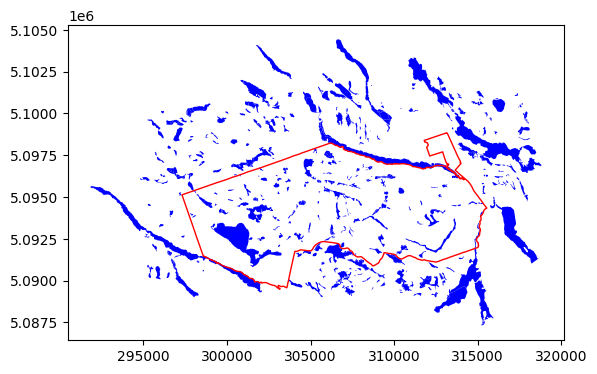

In [13]:
ax = water_gdf.plot(color='blue')
boundary_gdf.plot(ax=ax, facecolor='none',edgecolor='red')

## Load and clean ALS metrics

In [14]:
def fix_als_nm(nm):
    nm = (nm.
          replace('PRF_AR_FPC_', '')
          .replace('_M_wgs84', '')
          .replace('slice', 'd')
          .replace('_T0', '')
          .replace('_49', '')
          .replace('cm', '')
          .replace('T', '')
          .replace('density', 'dns')
          .replace('VCI_1m', 'vci_1mbin')
          .replace('VCI_pt5m', 'vci_0.5bin'))
    return nm

als_metrics_dir = os.path.join(DATA_DIR, r"SPL2018_EFI_predictors")

als_metrics_fpaths = glob(als_metrics_dir + r"/*.tif")

als_metrics_names = [os.path.basename(fpath).split('.')[0] for fpath in als_metrics_fpaths]

als_metrics_names = [fix_als_nm(nm) for nm in als_metrics_names]

print(f"Number of ALS metrics: {len(als_metrics_names)}\n")
print("\n".join(sorted(als_metrics_names)))

Number of ALS metrics: 67

avg
avg_95
b10
b20
b30
b40
b50
b60
b70
b80
b90
d0_2
d10_12
d12_14
d14_16
d16_18
d18_20
d20_22
d22_24
d24_26
d26_28
d28_30
d2_4
d30_32
d32_34
d34_36
d36_38
d38_40
d40_42
d42_44
d44_46
d46_48
d4_6
d6_8
d8_10
dns_10m
dns_12m
dns_14m
dns_15m
dns_16m
dns_18m
dns_20m
dns_25m
dns_2m
dns_4m
dns_5m
dns_6m
dns_8m
kur_95
p01
p05
p10
p20
p30
p40
p50
p60
p70
p80
p90
p95
p99
qav
skew_95
std_95
vci_0.5bin
vci_1mbin


In [15]:
# view enumerated band names
band_id_ls = list(enumerate(als_metrics_names, start=1))
band_id_ls = [str(nm) for nm in band_id_ls]
print("\n".join(band_id_ls))

(1, 'avg_95')
(2, 'avg')
(3, 'b10')
(4, 'b20')
(5, 'b30')
(6, 'b40')
(7, 'b50')
(8, 'b60')
(9, 'b70')
(10, 'b80')
(11, 'b90')
(12, 'dns_10m')
(13, 'dns_12m')
(14, 'dns_14m')
(15, 'dns_15m')
(16, 'dns_16m')
(17, 'dns_18m')
(18, 'dns_20m')
(19, 'dns_25m')
(20, 'dns_2m')
(21, 'dns_4m')
(22, 'dns_5m')
(23, 'dns_6m')
(24, 'dns_8m')
(25, 'kur_95')
(26, 'p01')
(27, 'p05')
(28, 'p10')
(29, 'p20')
(30, 'p30')
(31, 'p40')
(32, 'p50')
(33, 'p60')
(34, 'p70')
(35, 'p80')
(36, 'p90')
(37, 'p95')
(38, 'p99')
(39, 'qav')
(40, 'skew_95')
(41, 'd0_2')
(42, 'd10_12')
(43, 'd12_14')
(44, 'd14_16')
(45, 'd16_18')
(46, 'd18_20')
(47, 'd20_22')
(48, 'd22_24')
(49, 'd24_26')
(50, 'd26_28')
(51, 'd28_30')
(52, 'd2_4')
(53, 'd30_32')
(54, 'd32_34')
(55, 'd34_36')
(56, 'd36_38')
(57, 'd38_40')
(58, 'd40_42')
(59, 'd42_44')
(60, 'd44_46')
(61, 'd46_48')
(62, 'd4_6')
(63, 'd6_8')
(64, 'd8_10')
(65, 'std_95')
(66, 'vci_1mbin')
(67, 'vci_0.5bin')


In [16]:
# Read all ALS metrics rasters
metrics_ras_ls = []

for fpath in als_metrics_fpaths:

    print(f"Reading {os.path.basename(fpath)}...")

    with rasterio.open(fpath) as src:

        values = src.read()

        assert values.shape[0] == 1, "Expected single band raster"

        metrics_ras_ls.append(values)

# Read the profile of the first raster (assuming all rasters have the same profile)
with rasterio.open(als_metrics_fpaths[0]) as src:
    als_metrics_profile = src.profile

Reading PRF_AR_FPC_avg_95_T0_M_wgs84.tif...
Reading PRF_AR_FPC_avg_T0_M_wgs84.tif...
Reading PRF_AR_FPC_b10_T0cm_49_M_wgs84.tif...
Reading PRF_AR_FPC_b20_T0cm_49_M_wgs84.tif...
Reading PRF_AR_FPC_b30_T0cm_49_M_wgs84.tif...
Reading PRF_AR_FPC_b40_T0cm_49_M_wgs84.tif...
Reading PRF_AR_FPC_b50_T0cm_49_M_wgs84.tif...
Reading PRF_AR_FPC_b60_T0cm_49_M_wgs84.tif...
Reading PRF_AR_FPC_b70_T0cm_49_M_wgs84.tif...
Reading PRF_AR_FPC_b80_T0cm_49_M_wgs84.tif...
Reading PRF_AR_FPC_b90_T0cm_49_M_wgs84.tif...
Reading PRF_AR_FPC_density_T10m_M_wgs84.tif...
Reading PRF_AR_FPC_density_T12m_M_wgs84.tif...
Reading PRF_AR_FPC_density_T14m_M_wgs84.tif...
Reading PRF_AR_FPC_density_T15m_M_wgs84.tif...
Reading PRF_AR_FPC_density_T16m_M_wgs84.tif...
Reading PRF_AR_FPC_density_T18m_M_wgs84.tif...
Reading PRF_AR_FPC_density_T20m_M_wgs84.tif...
Reading PRF_AR_FPC_density_T25m_M_wgs84.tif...
Reading PRF_AR_FPC_density_T2m_M_wgs84.tif...
Reading PRF_AR_FPC_density_T4m_M_wgs84.tif...
Reading PRF_AR_FPC_density_T5m_M_

In [17]:
pprint(als_metrics_profile)

{'blockxsize': 128,
 'blockysize': 128,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 366,
 'interleave': 'band',
 'nodata': -3.4028234663852886e+38,
 'tiled': True,
 'transform': Affine(25.0, 0.0, 297349.8111540888,
       0.0, -25.0, 5099001.016618513),
 'width': 746}


In [18]:
# Combine arrays into single raster
als_metrics_ras = np.concatenate(metrics_ras_ls, axis=0)

# Replace nodata values with NaN
als_metrics_ras = np.where(als_metrics_ras == als_metrics_profile['nodata'], np.nan, als_metrics_ras)
als_metrics_ras

als_metrics_ras.shape

(67, 366, 746)

In [19]:
print(np.nanmin(als_metrics_ras[0]))
print(np.nanmax(als_metrics_ras[0]))

0.0
30.33


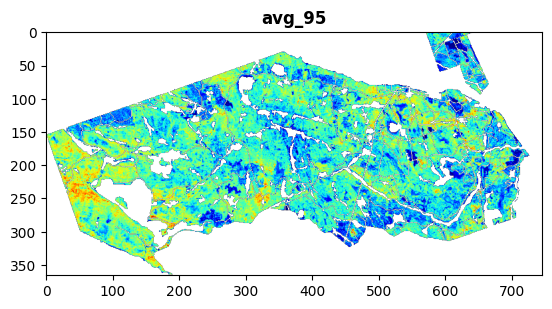

<Axes: title={'center': 'avg_95'}>

In [20]:
show(als_metrics_ras[0], cmap='jet', title=als_metrics_names[0])

## Subset and clean LiDAR data

In [21]:
lidar_index_fpath = os.path.join(DATA_DIR, r'lidar/OMNRF_Petawawa_sheets_updated.shp')
lidar_index = gpd.read_file(lidar_index_fpath)

1kmZ183060509402018L


<Axes: >

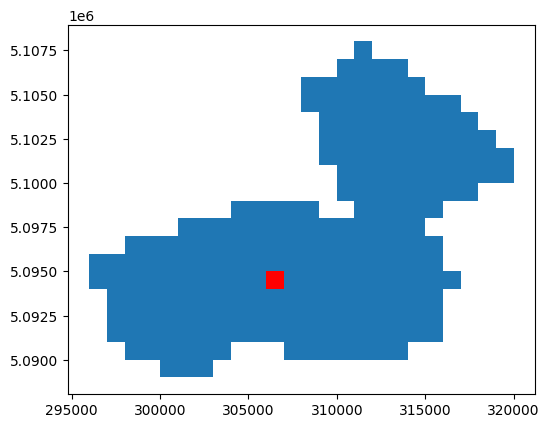

In [22]:
target_refname = lidar_index['RefName_1'][74]

print(target_refname)

lidar_sub_gdf = lidar_index[lidar_index['RefName_1'] == target_refname].copy()

ax = lidar_index.plot()

lidar_sub_gdf.plot(ax=ax, color='red')


In [23]:
# Read the laz file
pc_fpath = os.path.join(DATA_DIR, r'lidar/1kmZ183060509402018L.laz')

las = laspy.read(pc_fpath)

crs = las.header.parse_crs()

print(f"LAS CRS: {crs}")

print(f"LAS Header: {las.header}")

points = np.vstack([las.x, las.y, las.z]).transpose()


LAS CRS: COMPD_CS["NAD83(CSRS) / UTM zone 18N + CGVD2013 height - CGG2013 - NAD83(CSRS)",PROJCS["NAD83(CSRS) / UTM zone 18N",GEOGCS["NAD83(CSRS)",DATUM["NAD83_Canadian_Spatial_Reference_System",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6140"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4617"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2959"]],VERT_CS["CGVD2013 height - CGG2013 - NAD83(CSRS)",VERT_DATUM["Canadian Geodetic Vertical Datum of 2013",2005,AUTHORITY["EPSG","1127"]],HEIGHT_MODEL["CGG2013 NAD83"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6647"]]]
LAS Header: <L

<Axes: >

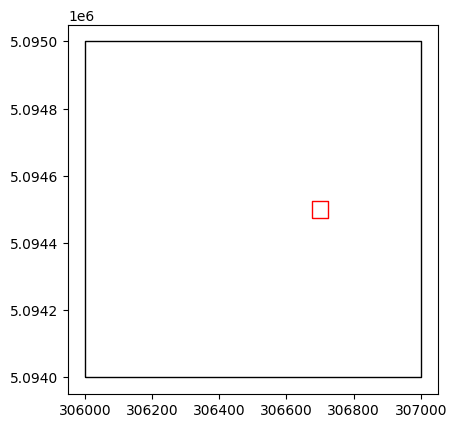

In [24]:
# Apply a negative buffer to the sub area
buffer = -475
lidar_sub_gdf_red = lidar_sub_gdf.copy()
lidar_sub_gdf_red.geometry = lidar_sub_gdf.buffer(buffer)

# Translate bbox 100m to the right
lidar_sub_gdf_red.geometry = lidar_sub_gdf_red.translate(xoff=200, yoff=0)

ax = lidar_sub_gdf.plot(facecolor='none', edgecolor='black', linewidth=1)
lidar_sub_gdf_red.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)


In [25]:
# Clip points to negative buffer

# Get buffer bounds
bounds = lidar_sub_gdf_red.bounds

# Get points within bounds
mask = ((points[:, 0] >= bounds['minx'].values[0]) & \
       (points[:, 0] <= bounds['maxx'].values[0]) & \
       (points[:, 1] >= bounds['miny'].values[0]) & \
       (points[:, 1] <= bounds['maxy'].values[0]))

# Get clipped points
clipped_points = points[mask]
print(clipped_points.shape)

(79223, 3)


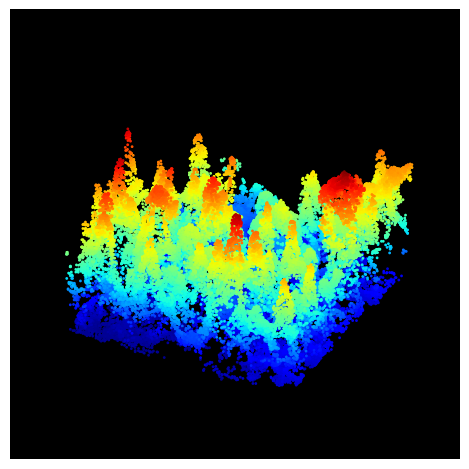

In [26]:
plot_pc(clipped_points, pt_size = 1)

## Sentinel-2 Imagery

Sentinel-2 imagery was downloaded using Google Earth Engine. You can see the code at the following link:

https://code.earthengine.google.com/e0a63220c15068398d6d432be5e3ccb8

The dataset is described in more detail at the link below:

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED

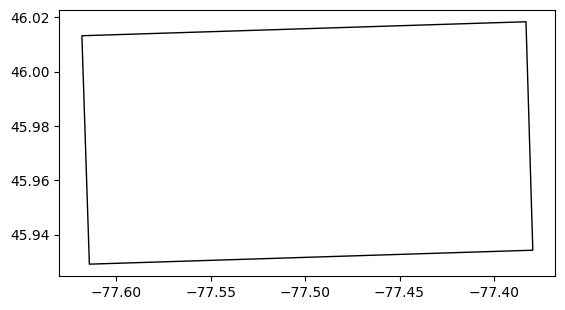

In [27]:
# Create a bounding box for GEE download

prf_bounds = boundary_gdf.total_bounds

prf_bbox_gdf = gpd.GeoDataFrame(index=[0], 
                       crs=boundary_gdf.crs, 
                       geometry=[geometry.box(*prf_bounds)])

# Reproject to web mercator
prf_bbox_gdf = prf_bbox_gdf.to_crs(epsg=4326)

prf_bbox_gdf.plot(facecolor='none', edgecolor='black', linewidth=1)

prf_bbox_fpath = os.path.join(DATA_DIR, r"prf_bbox.shp")

prf_bbox_gdf.to_file(prf_bbox_fpath)

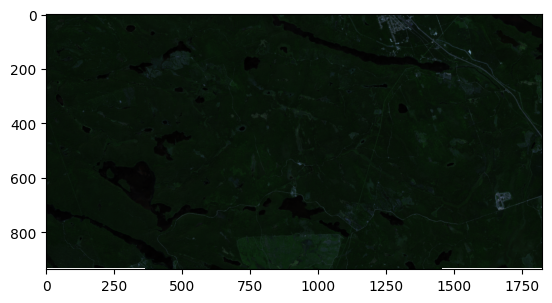

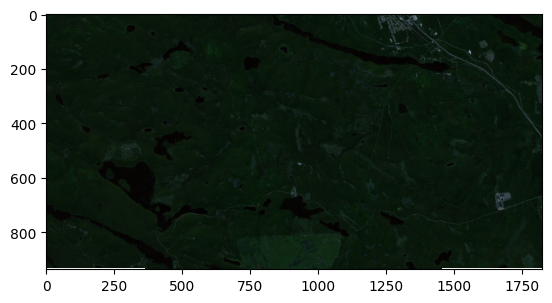

<Axes: >

In [28]:
# Load and visualize imagery

s2_2018_fpath = os.path.join(DATA_DIR, r"petawawa_s2_2018.tif")
s2_2024_fpath = os.path.join(DATA_DIR, r"petawawa_s2_2024.tif")

s2_2018 = rio.open_rasterio(s2_2018_fpath)
s2_2024 = rio.open_rasterio(s2_2024_fpath)

show(s2_2018.values[1:4], adjust=True)
show(s2_2024.values[1:4], adjust=True)

## Check CRS of all spatial data

In [29]:
print("Boundary:", boundary_gdf.crs)
print("Plots", plots_2018_gdf.crs)
print("Water", water_gdf.crs)
print("ALS Metrics Raster", als_metrics_profile['crs'])
print("Lidar Index", lidar_index.crs, "(note that this is different because lidar CRS accounts for Z-axis)")

Boundary: EPSG:32618
Plots EPSG:32618
Water EPSG:32618
ALS Metrics Raster EPSG:32618
Lidar Index EPSG:2959 (note that this is different because lidar CRS accounts for Z-axis)


 ## Export and Compress Data <a class="anchor" id="export"></a>

In [30]:
out_dict = {
    'boundary': os.path.join(OUT_DATA_DIR, r'boundary.gpkg'),
    'trees': os.path.join(OUT_DATA_DIR, r'trees.csv'),
    'plots': os.path.join(OUT_DATA_DIR, r'plots.gpkg'),
    'water': os.path.join(OUT_DATA_DIR, r'water.gpkg'),
    'als_metrics': os.path.join(OUT_DATA_DIR, r'als_metrics.tif'),
    'lidar': os.path.join(OUT_DATA_DIR, r"forest_point_cloud.las"),
    'lidar_footprint': os.path.join(OUT_DATA_DIR, r"forest_point_cloud_footprint.gpkg"),
    's2_2018': os.path.join(OUT_DATA_DIR, r"petawawa_s2_2018.tif"),
    's2_2024': os.path.join(OUT_DATA_DIR, r"petawawa_s2_2024.tif"),
}

pprint(out_dict)

{'als_metrics': 'data\\als_metrics.tif',
 'boundary': 'data\\boundary.gpkg',
 'lidar': 'data\\forest_point_cloud.las',
 'lidar_footprint': 'data\\forest_point_cloud_footprint.gpkg',
 'plots': 'data\\plots.gpkg',
 's2_2018': 'data\\petawawa_s2_2018.tif',
 's2_2024': 'data\\petawawa_s2_2024.tif',
 'trees': 'data\\trees.csv',
 'water': 'data\\water.gpkg'}


In [32]:
# Export vector data
boundary_gdf.to_file(out_dict['boundary'], driver='GPKG', index=False)
trees_df.to_csv(out_dict['trees'], index=False)
plots_2018_gdf.to_file(out_dict['plots'], driver='GPKG', index=False)
water_gdf.to_file(out_dict['water'], driver='GPKG', index=False)
lidar_sub_gdf_red.to_file(out_dict['lidar_footprint'], driver='GPKG', index=False)

# Export combined ALS metric raster
als_metrics_profile.update({'count': len(als_metrics_names)})

with rasterio.open(out_dict['als_metrics'], 'w', **als_metrics_profile) as dst:
    for i, band in enumerate(als_metrics_ras):

        band = als_metrics_ras[i]

        dst.write(band, i + 1)

        dst.set_band_description(i + 1, als_metrics_names[i])

# Copy downloaded rasters to the out data directory
for fpath in [s2_2018_fpath, s2_2024_fpath]:
    out_fpath = os.path.join(OUT_DATA_DIR, os.path.basename(fpath))
    shutil.copy(fpath, out_fpath)
    print(f"Copied {fpath} to {out_fpath}")

# Export lidar data
write_las(clipped_points, out_dict['lidar'])

pprint(out_dict)

Copied data/original\petawawa_s2_2018.tif to data\petawawa_s2_2018.tif
Copied data/original\petawawa_s2_2024.tif to data\petawawa_s2_2024.tif
{'als_metrics': 'data\\als_metrics.tif',
 'boundary': 'data\\boundary.gpkg',
 'lidar': 'data\\forest_point_cloud.las',
 'lidar_footprint': 'data\\forest_point_cloud_footprint.gpkg',
 'plots': 'data\\plots.gpkg',
 's2_2018': 'data\\petawawa_s2_2018.tif',
 's2_2024': 'data\\petawawa_s2_2024.tif',
 'trees': 'data\\trees.csv',
 'water': 'data\\water.gpkg'}


In [33]:
# Zip data so it can be uploaded to google drive

zip_file_name = 'prf_data.zip'

files_to_compress = out_dict.values()

zip_object = zipfile.ZipFile(zip_file_name, 'w')

print(f"Zipping following files into {zip_file_name}:\n\n{"\n".join(files_to_compress)}")

for file_name in files_to_compress:
    zip_object.write(file_name, arcname=os.path.basename(file_name), compress_type=zipfile.ZIP_DEFLATED)

zip_object.close()

print(f"Data zipped to {zip_file_name}")

Zipping following files into prf_data.zip:

data\boundary.gpkg
data\trees.csv
data\plots.gpkg
data\water.gpkg
data\als_metrics.tif
data\forest_point_cloud.las
data\forest_point_cloud_footprint.gpkg
data\petawawa_s2_2018.tif
data\petawawa_s2_2024.tif
Data zipped to prf_data.zip
